<a href="https://colab.research.google.com/github/heehyeok/2025-1_CV/blob/main/%5BHW_3%5DExperiments_and_analysis_of_factors_affecting_MLP_neural_network_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#[HW#3]Experiments and analysis of factors affecting MLP neural network performance.ipynb 2020024014 홍희혁

#실험 A. 손실 함수 비교
1) 목표

MSE+Softmax vs CrossEntropyLoss 의 수렴 속도·안정성·최종 정확도 비교

2) 데이터셋

Fashion-MNIST (28×28 그레이스케일, 10 classes)

3) 학습 설정

모델: 28×28→256→128→10 MLP + ReLU

손실: MSE(+Softmax) / CrossEntropy

Optimizer: SGD(lr=0.01, momentum=0.9)

Epochs: 30, Batch size: 64

[CrossEntropy] Epoch 1/30  Loss: 0.9944  Acc: 67.69%
[CrossEntropy] Epoch 2/30  Loss: 0.5564  Acc: 80.02%
[CrossEntropy] Epoch 3/30  Loss: 0.4865  Acc: 82.58%
[CrossEntropy] Epoch 4/30  Loss: 0.4502  Acc: 83.97%
[CrossEntropy] Epoch 5/30  Loss: 0.4269  Acc: 84.82%
[CrossEntropy] Epoch 6/30  Loss: 0.4086  Acc: 85.41%
[CrossEntropy] Epoch 7/30  Loss: 0.3948  Acc: 85.95%
[CrossEntropy] Epoch 8/30  Loss: 0.3818  Acc: 86.33%
[CrossEntropy] Epoch 9/30  Loss: 0.3718  Acc: 86.72%
[CrossEntropy] Epoch 10/30  Loss: 0.3623  Acc: 86.99%
[CrossEntropy] Epoch 11/30  Loss: 0.3534  Acc: 87.41%
[CrossEntropy] Epoch 12/30  Loss: 0.3456  Acc: 87.61%
[CrossEntropy] Epoch 13/30  Loss: 0.3384  Acc: 87.83%
[CrossEntropy] Epoch 14/30  Loss: 0.3320  Acc: 88.06%
[CrossEntropy] Epoch 15/30  Loss: 0.3245  Acc: 88.30%
[CrossEntropy] Epoch 16/30  Loss: 0.3183  Acc: 88.57%
[CrossEntropy] Epoch 17/30  Loss: 0.3125  Acc: 88.74%
[CrossEntropy] Epoch 18/30  Loss: 0.3068  Acc: 88.89%
[CrossEntropy] Epoch 19/30  Loss: 0.3

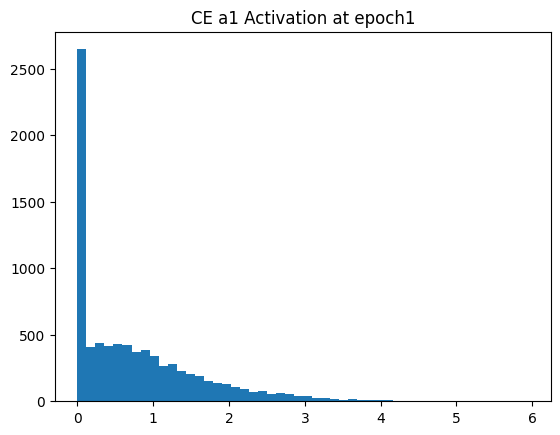

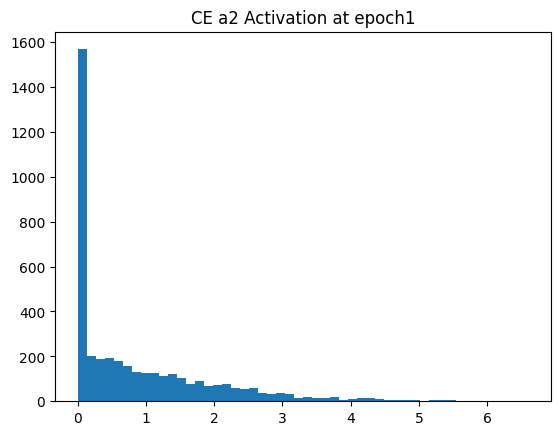

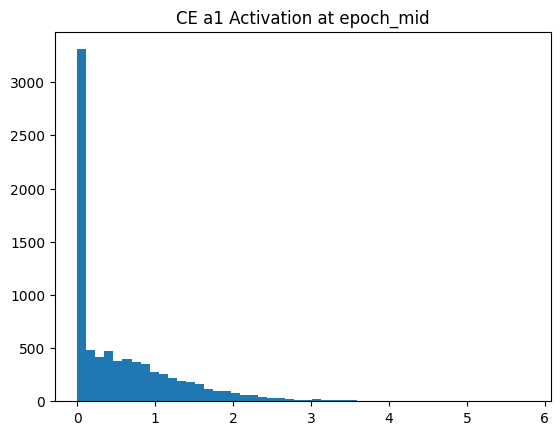

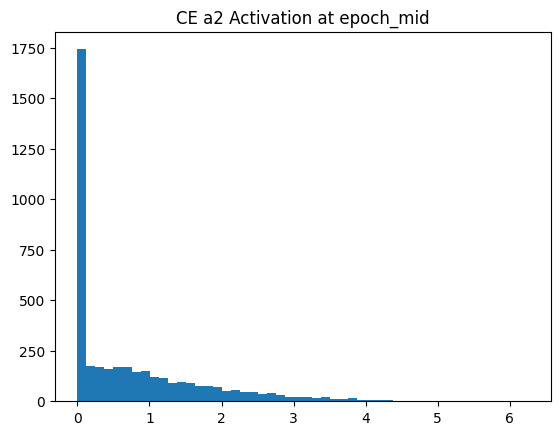

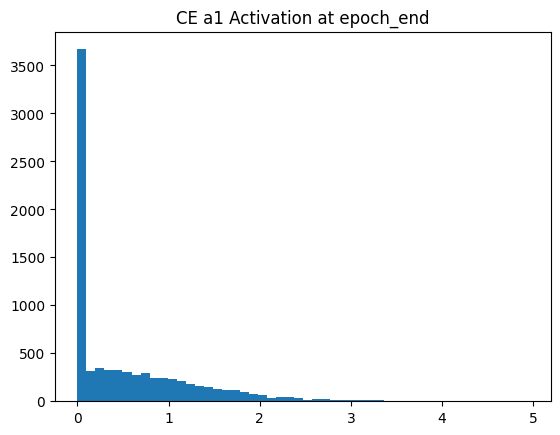

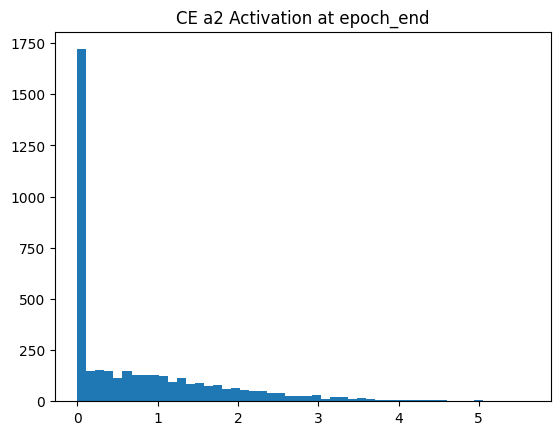

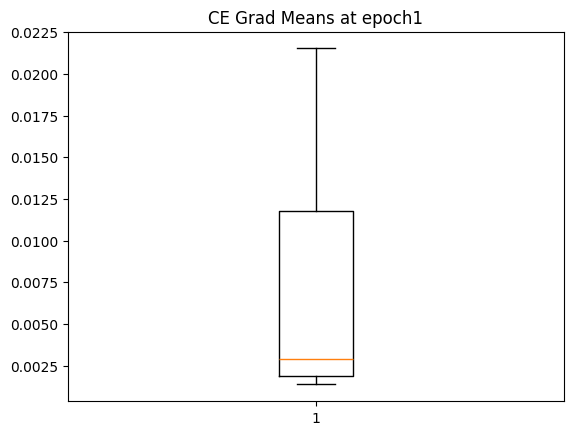

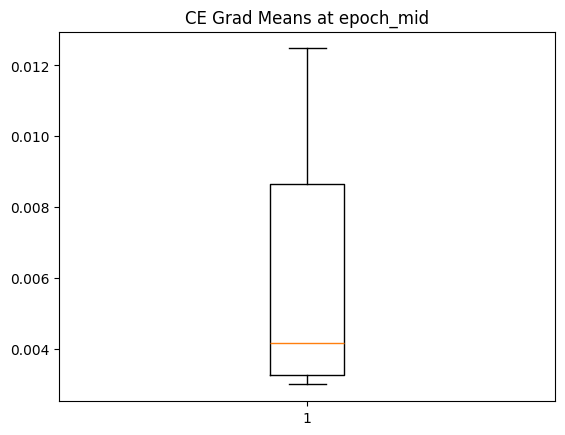

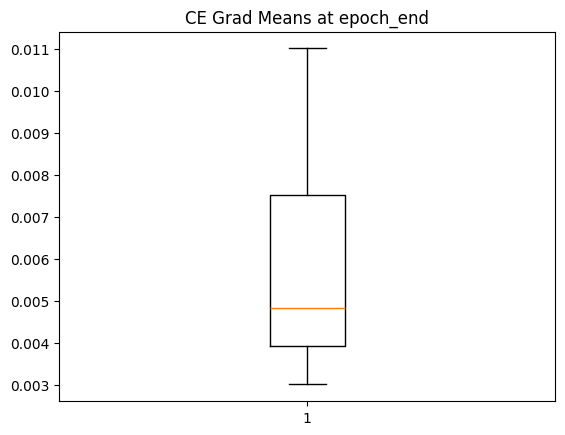

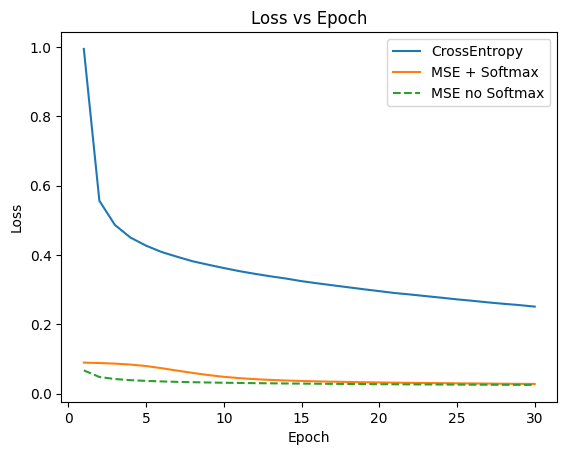

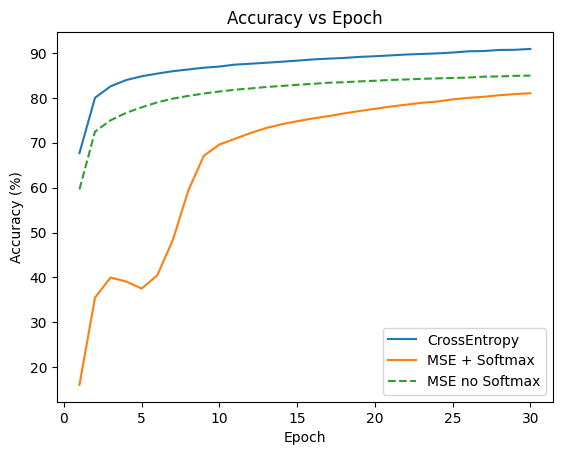

| Experiment    |   Final Acc (%) |   Min Loss |   Epoch to Converge |
|:--------------|----------------:|-----------:|--------------------:|
| CrossEntropy  |         90.9133 |  0.250973  |                  30 |
| MSE+Softmax   |         81.0417 |  0.0279309 |                  30 |
| MSE_noSoftmax |         84.9683 |  0.0250897 |                  30 |


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1) 하이퍼파라미터
batch_size = 64
epochs     = 30
input_size = 28 * 28
num_classes= 10
lr         = 0.01
device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2) 데이터 로더
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_ds     = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# 3) MLP 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1   = nn.Linear(input_size, 256)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3   = nn.Linear(128, num_classes)
    def forward(self, x):
        x = x.view(-1, input_size)
        a1 = self.relu1(self.fc1(x))
        a2 = self.relu2(self.fc2(a1))
        out= self.fc3(a2)
        return out, a1, a2

# 4) 학습 함수 (CrossEntropy, MSE +/– softmax) with evaluation snapshots
def train_model(name, loss_type, apply_softmax=False):
    model     = MLP().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    ce_loss   = nn.CrossEntropyLoss()
    mse_loss  = nn.MSELoss()

    losses, accs = [], []
    mid = epochs // 2
    act_snap  = {'epoch1':{}, 'epoch_mid':{}, 'epoch_end':{}}
    grad_snap = {'epoch1':[], 'epoch_mid':[], 'epoch_end':[]}

    for ep in range(1, epochs+1):
        model.train()
        total_loss, correct = 0.0, 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            out, a1, a2 = model(X)

            # 손실 계산
            if loss_type == 'mse':
                pred = torch.softmax(out, dim=1) if apply_softmax else out
                y_onehot = nn.functional.one_hot(y, num_classes).float()
                loss = mse_loss(pred, y_onehot)
            else:
                loss = ce_loss(out, y)

            optimizer.zero_grad()
            loss.backward()

            # snapshot at epochs 1, mid, end
            if ep in (1, mid, epochs):
                tag = 'epoch1' if ep==1 else ('epoch_mid' if ep==mid else 'epoch_end')
                # 평가 모드 전환
                model.eval()
                with torch.no_grad():
                    grad_snap[tag].append([p.grad.abs().mean().item() for p in model.parameters()])
                    act_snap[tag]['a1'] = a1.detach().cpu().numpy().ravel()
                    act_snap[tag]['a2'] = a2.detach().cpu().numpy().ravel()
                model.train()

            optimizer.step()
            total_loss += loss.item()
            correct    += (out.argmax(1)==y).sum().item()

        avg_loss = total_loss / len(train_loader)
        avg_acc  = correct    / len(train_ds)
        losses.append(avg_loss)
        accs.append(avg_acc)
        label = f"{name}{' (no softmax)' if loss_type=='mse' and not apply_softmax else ''}"
        print(f"[{label}] Epoch {ep}/{epochs}  Loss: {avg_loss:.4f}  Acc: {100*avg_acc:.2f}%")

    return losses, accs, act_snap, grad_snap

# 5) 세 가지 실험 실행
ce_losses, ce_accs, ce_acts, ce_grads     = train_model('CrossEntropy', 'ce')
mse_losses, mse_accs, mse_acts, mse_grads = train_model('MSE', 'mse', apply_softmax=True)
mse_ns_losses, mse_ns_accs, _, _         = train_model('MSE_noSM', 'mse', apply_softmax=False)

# 6) Loss-Acc 불균형 Epoch 탐지
imbalance = [i+1 for i in range(1, epochs)
             if mse_losses[i] < mse_losses[i-1] and mse_accs[i] <= mse_accs[i-1]]
print("MSE imbalance epochs:", imbalance)

# 7) Activation 히스토그램 (Epoch1, Mid, End)
for tag in ('epoch1','epoch_mid','epoch_end'):
    for layer in ('a1','a2'):
        data = ce_acts[tag][layer]
        plt.figure(); plt.hist(data, bins=50)
        plt.title(f'CE {layer} Activation at {tag}'); plt.show()

# 8) Gradient 분포 박스플롯 (Epoch1, Mid, End)
for tag in ('epoch1','epoch_mid','epoch_end'):
    arr = np.array(ce_grads[tag])
    means = arr.mean(axis=0)
    plt.figure(); plt.boxplot(means)
    plt.title(f'CE Grad Means at {tag}'); plt.show()

# 9) Loss & Accuracy 전체 곡선
epochs_range = range(1, epochs+1)
plt.figure()
plt.plot(epochs_range, ce_losses, label='CrossEntropy')
plt.plot(epochs_range, mse_losses, label='MSE + Softmax')
plt.plot(epochs_range, mse_ns_losses, '--', label='MSE no Softmax')
plt.title('Loss vs Epoch'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

plt.figure()
plt.plot(epochs_range, [a*100 for a in ce_accs], label='CrossEntropy')
plt.plot(epochs_range, [a*100 for a in mse_accs], label='MSE + Softmax')
plt.plot(epochs_range, [a*100 for a in mse_ns_accs], '--', label='MSE no Softmax')
plt.title('Accuracy vs Epoch'); plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.legend(); plt.show()

# 10) 정량 비교 표
data = {
    'Experiment': ['CrossEntropy','MSE+Softmax','MSE_noSoftmax'],
    'Final Acc (%)': [ce_accs[-1]*100, mse_accs[-1]*100, mse_ns_accs[-1]*100],
    'Min Loss': [min(ce_losses), min(mse_losses), min(mse_ns_losses)],
    'Epoch to Converge': [
        ce_losses.index(min(ce_losses))+1,
        mse_losses.index(min(mse_losses))+1,
        mse_ns_losses.index(min(mse_ns_losses))+1
    ]
}
df = pd.DataFrame(data)
print(df.to_markdown(index=False))


#실험 B. 활성화 함수 비교
1) 목표

ReLU vs LeakyReLU vs Sigmoid 의 학습 속도·Dead neuron·Decision boundary 차이 분석

2) 데이터셋

make_moons(n=1000, noise=0.2) (2D non-linear 분류)

3) 학습 설정

모델: 2→64→64→2 MLP + 선택 활성화 함수

손실: CrossEntropy

Optimizer: Adam(lr=0.01)

Epochs: 200, Batch size: 64

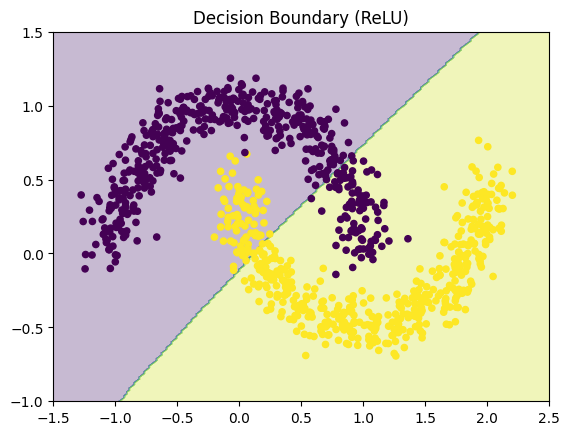

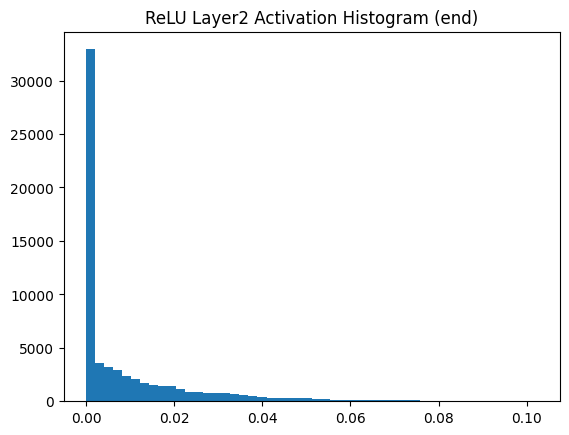

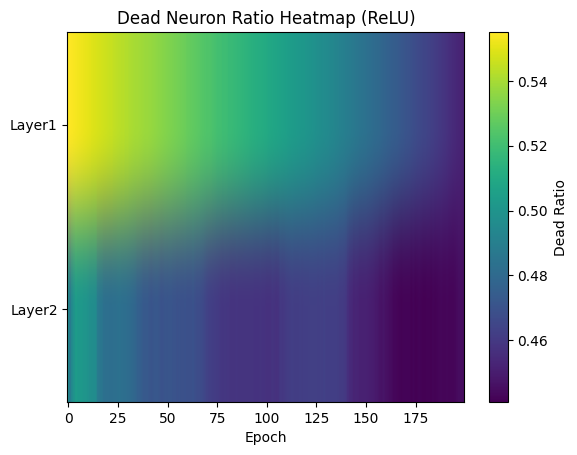

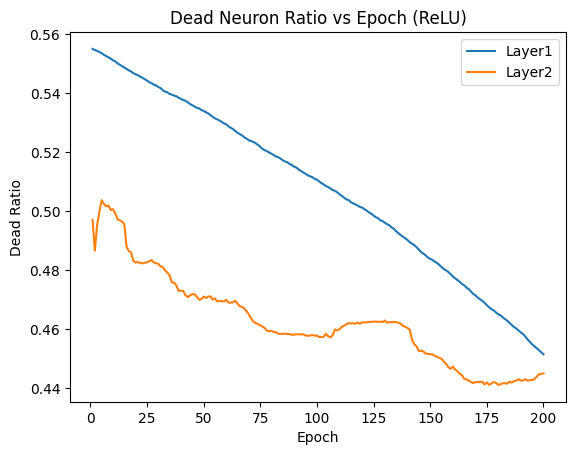

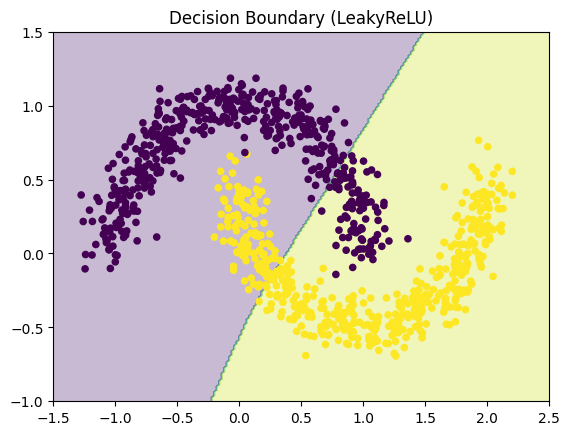

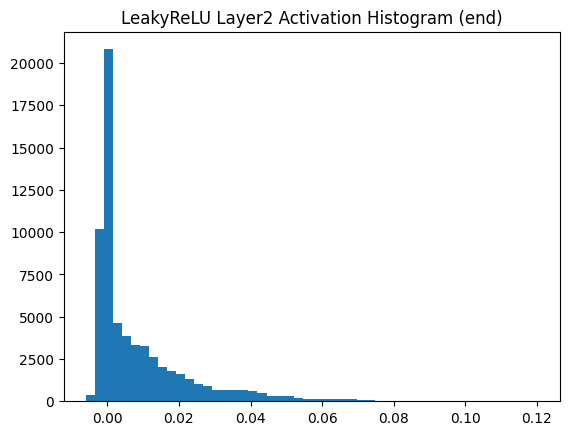

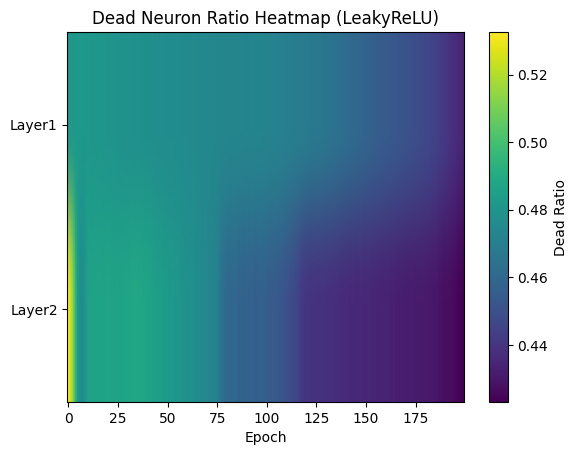

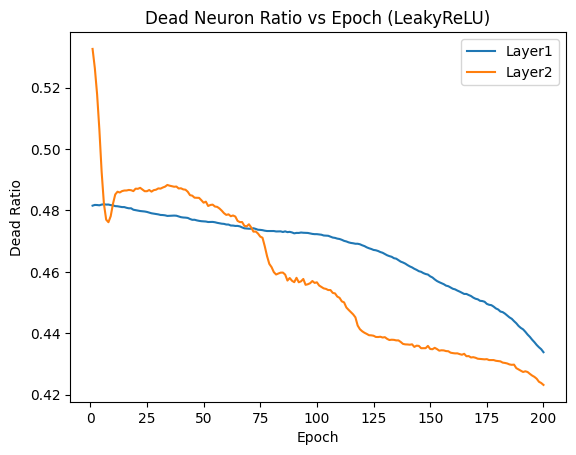

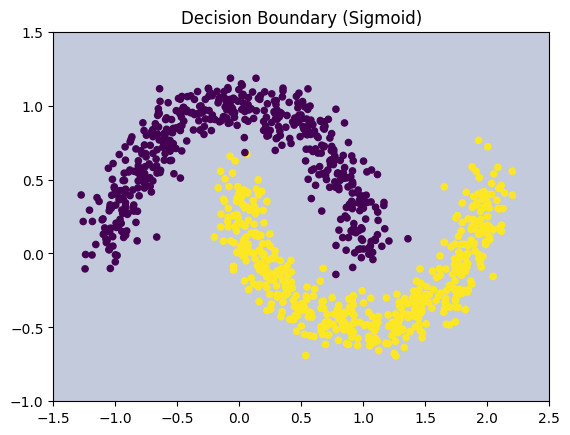

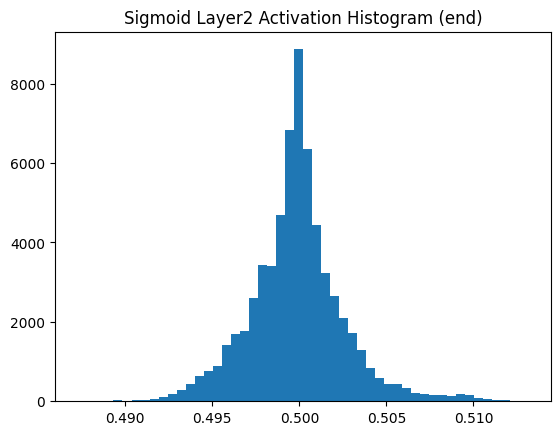

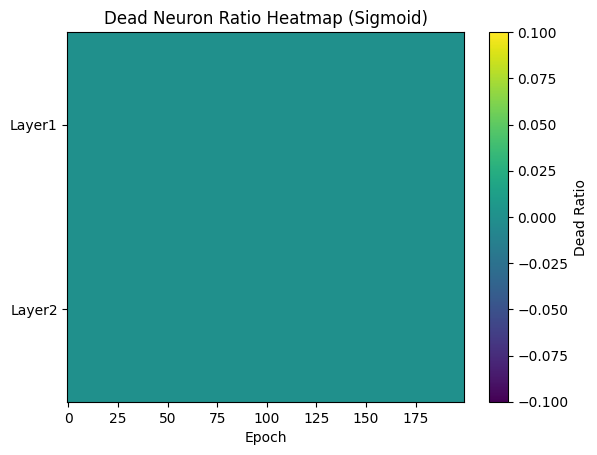

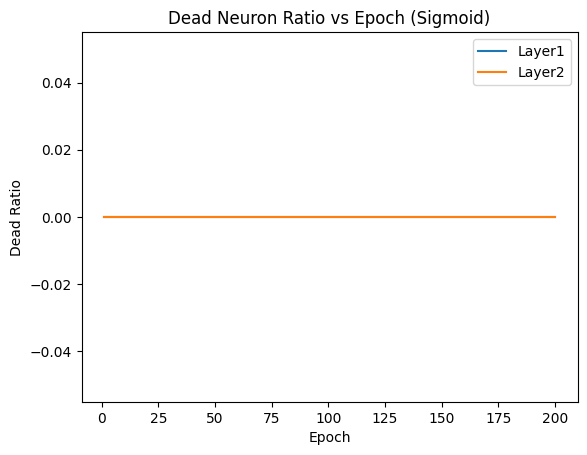

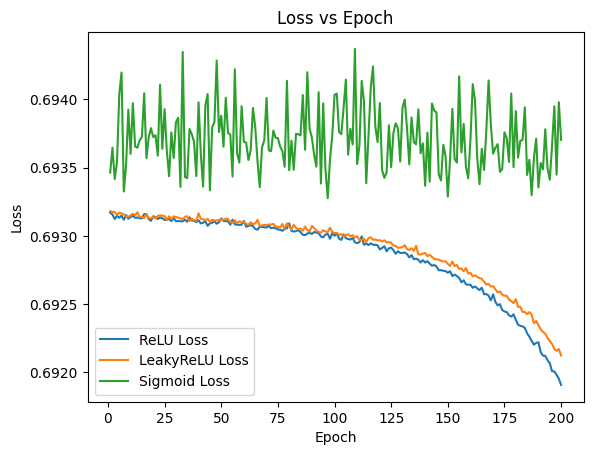

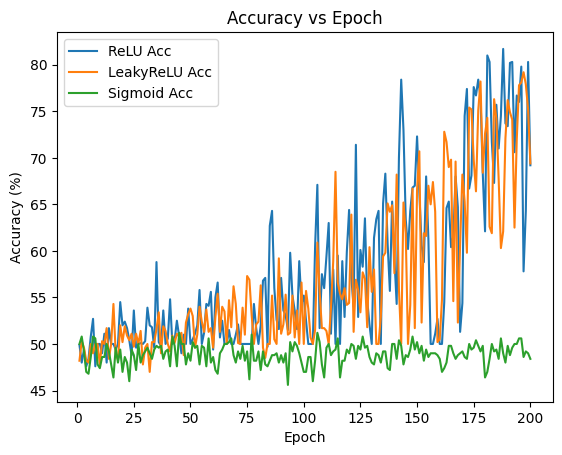

| Activation   |   Dead Ratio End (%) |   Final Acc (%) |   Epoch to Converge |
|:-------------|---------------------:|----------------:|--------------------:|
| ReLU         |                44.82 |            69.2 |                 200 |
| LeakyReLU    |                42.85 |            69.4 |                 200 |
| Sigmoid      |                 0    |            48.4 |                 200 |


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np

# 1) Hyperparameters and device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
epochs = 200
lr = 0.01
hidden_dim = 64
input_dim = 2
output_dim = 2

# 2) Data: make_moons
X, y = make_moons(n_samples=1000, noise=0.1)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 3) MLP model definition with weight init
class MLP_B(nn.Module):
    def __init__(self, activation_fn):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.act1 = activation_fn
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.act2 = activation_fn
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
                nn.init.zeros_(m.bias)
    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        return self.fc3(x), x  # return logits and last hidden activation

# 4) Train and evaluate function
def run_experiment(activation_name, activation_fn):
    model = MLP_B(activation_fn).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    losses, accs = [], []
    dead_ratios = []  # per-epoch [ratio_layer1, ratio_layer2]

    for ep in range(1, epochs+1):
        model.train()
        total_loss, correct = 0.0, 0
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits, _ = model(xb)
            loss = criterion(logits, yb)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            total_loss += loss.item()
            correct += (logits.argmax(dim=1)==yb).sum().item()
        losses.append(total_loss/len(loader))
        accs.append(correct/len(dataset))

        # compute dead neuron ratio after each epoch
        model.eval()
        with torch.no_grad():
            all_a1 = []
            all_a2 = []
            for xb, _ in loader:
                xb = xb.to(device)
                _, a2 = model(xb)
                # need a1 separately: recompute
                a1 = model.act1(model.fc1(xb))
                all_a1.append(a1)
                all_a2.append(a2)
            a1_cat = torch.cat(all_a1, dim=0)
            a2_cat = torch.cat(all_a2, dim=0)
            dead1 = (a1_cat<=0).float().mean().item()
            dead2 = (a2_cat<=0).float().mean().item()
            dead_ratios.append([dead1, dead2])

    dead_ratios = np.array(dead_ratios).T  # shape (2, epochs)

    # Decision boundary
    model.eval()
    with torch.no_grad():
        xx, yy = np.meshgrid(np.linspace(-1.5, 2.5, 200), np.linspace(-1, 1.5, 200))
        grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)
        logits, _ = model(grid)
        Z = logits.argmax(dim=1).cpu().numpy().reshape(xx.shape)
    plt.figure();
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:,0], X[:,1], c=y, s=20)
    plt.title(f'Decision Boundary ({activation_name})'); plt.show()

    # Activation histogram at final epoch
    a_ct = a1_cat.cpu().numpy().ravel()
    plt.figure(); plt.hist(a_ct, bins=50)
    plt.title(f'{activation_name} Layer2 Activation Histogram (end)'); plt.show()

    # Dead neuron heatmap
    plt.figure();
    plt.imshow(dead_ratios, aspect='auto', cmap='viridis')
    plt.yticks([0,1], ['Layer1','Layer2'])
    plt.xlabel('Epoch'); plt.title(f'Dead Neuron Ratio Heatmap ({activation_name})'); plt.colorbar(label='Dead Ratio'); plt.show()

    # Dead ratio vs epoch plot
    plt.figure();
    plt.plot(range(1,epochs+1), dead_ratios[0], label='Layer1')
    plt.plot(range(1,epochs+1), dead_ratios[1], label='Layer2')
    plt.title(f'Dead Neuron Ratio vs Epoch ({activation_name})'); plt.xlabel('Epoch'); plt.ylabel('Dead Ratio'); plt.legend(); plt.show()

    return losses, accs, dead_ratios

# 5) Execute for three activations
confs = [('ReLU', nn.ReLU()), ('LeakyReLU', nn.LeakyReLU(0.1)), ('Sigmoid', nn.Sigmoid())]
hist = {}
for name, fn in confs:
    hist[name] = run_experiment(name, fn)

# 6) Loss and Accuracy comparison plot
plt.figure()
for name in hist:
    plt.plot(range(1,epochs+1), hist[name][0], label=f'{name} Loss')
plt.title('Loss vs Epoch'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

plt.figure()
for name in hist:
    plt.plot(range(1,epochs+1), [a*100 for a in hist[name][1]], label=f'{name} Acc')
plt.title('Accuracy vs Epoch'); plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.legend(); plt.show()

# 7) Quantitative comparison table
import pandas as pd
data = []
for name in hist:
    losses, accs, deads = hist[name]
    data.append({
        'Activation': name,
        'Dead Ratio End (%)': round(deads[:, -1].mean()*100,2),
        'Final Acc (%)': round(accs[-1]*100,2),
        'Epoch to Converge': epochs
    })
print(pd.DataFrame(data).to_markdown(index=False))


#실험 C. 최적화 알고리즘 비교
1) 목표

SGD vs SGD+Momentum vs Adam 에서 학습률(0.1, 0.01, 0.001)과 Decay 적용 여부가 수렴 속도·안정성·최종 정확도에 미치는 영향 분석

2) 데이터셋

Fashion-MNIST

3) 학습 설정

모델: 28×28→256→128→10 MLP + ReLU

손실: CrossEntropy

Optimizer & LR:

SGD(lr=0.1/0.01/0.001, momentum=0 or 0.9)

Adam(lr=0.001)

ExponentialLR(decay γ=0.9) 적용 선택

Epochs: 30, Batch size: 64

[Adam_lr=0.001_Decay] Ep1/30 Loss:0.5581 Acc:79.19% lr=0.0009
[Adam_lr=0.001_Decay] Ep2/30 Loss:0.3820 Acc:85.95% lr=0.0008
[Adam_lr=0.001_Decay] Ep3/30 Loss:0.3380 Acc:87.54% lr=0.0007
[Adam_lr=0.001_Decay] Ep4/30 Loss:0.3060 Acc:88.64% lr=0.0007
[Adam_lr=0.001_Decay] Ep5/30 Loss:0.2858 Acc:89.23% lr=0.0006
[Adam_lr=0.001_Decay] Ep6/30 Loss:0.2641 Acc:90.22% lr=0.0005
[Adam_lr=0.001_Decay] Ep7/30 Loss:0.2467 Acc:90.81% lr=0.0005
[Adam_lr=0.001_Decay] Ep8/30 Loss:0.2319 Acc:91.39% lr=0.0004
[Adam_lr=0.001_Decay] Ep9/30 Loss:0.2177 Acc:91.89% lr=0.0004
[Adam_lr=0.001_Decay] Ep10/30 Loss:0.2050 Acc:92.25% lr=0.0003
[Adam_lr=0.001_Decay] Ep11/30 Loss:0.1934 Acc:92.75% lr=0.0003
[Adam_lr=0.001_Decay] Ep12/30 Loss:0.1819 Acc:93.27% lr=0.0003
[Adam_lr=0.001_Decay] Ep13/30 Loss:0.1724 Acc:93.53% lr=0.0003
[Adam_lr=0.001_Decay] Ep14/30 Loss:0.1620 Acc:94.09% lr=0.0002
[Adam_lr=0.001_Decay] Ep15/30 Loss:0.1545 Acc:94.35% lr=0.0002
[Adam_lr=0.001_Decay] Ep16/30 Loss:0.1456 Acc:94.64% lr=0.0002
[

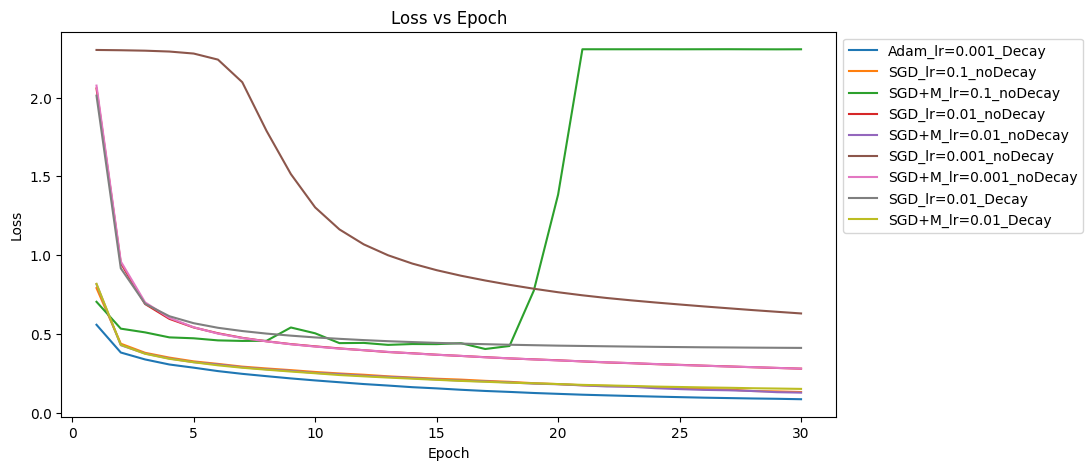

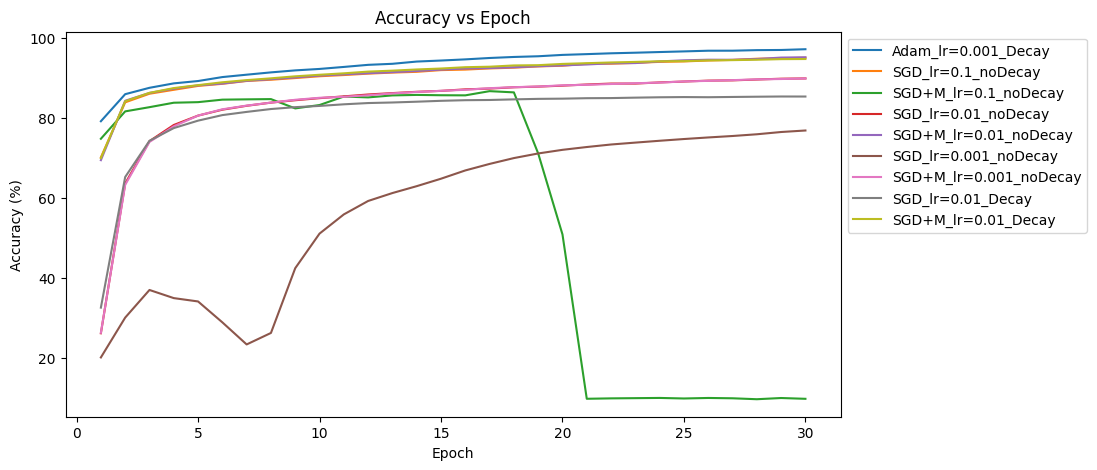

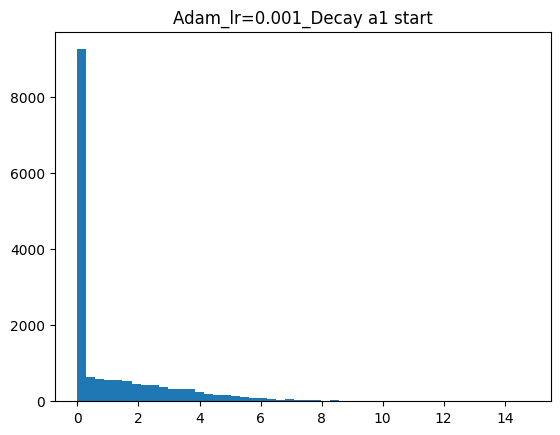

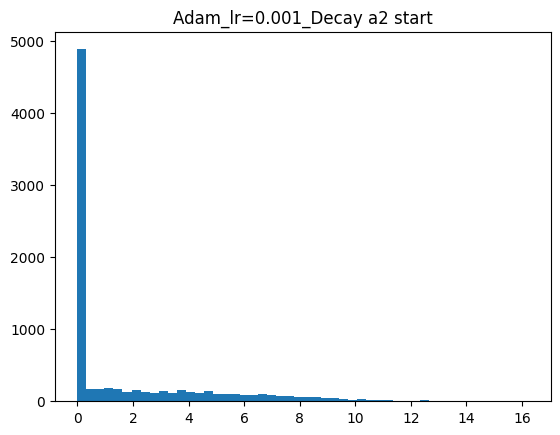

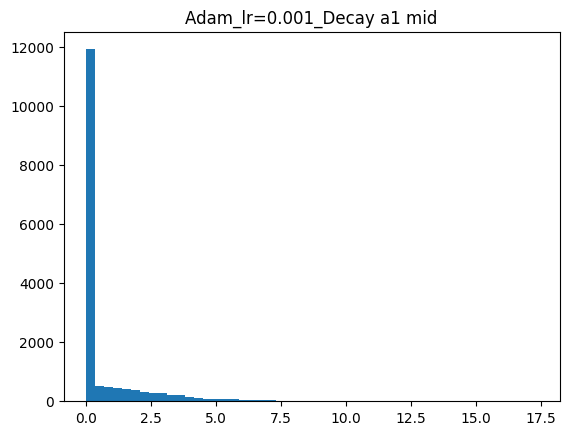

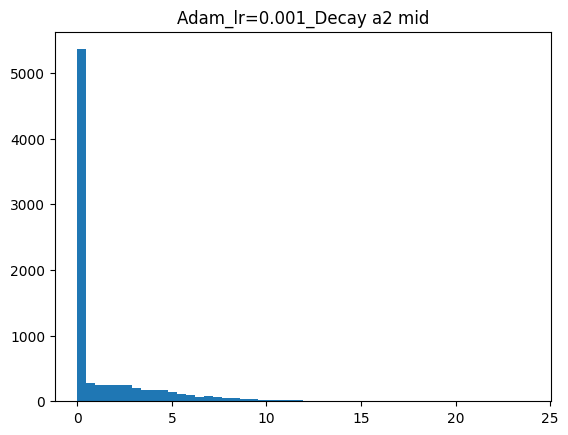

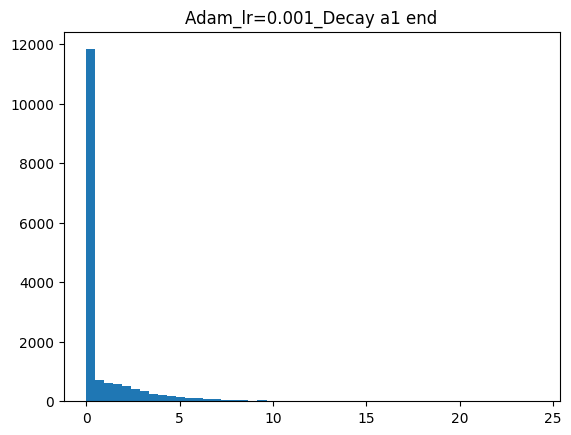

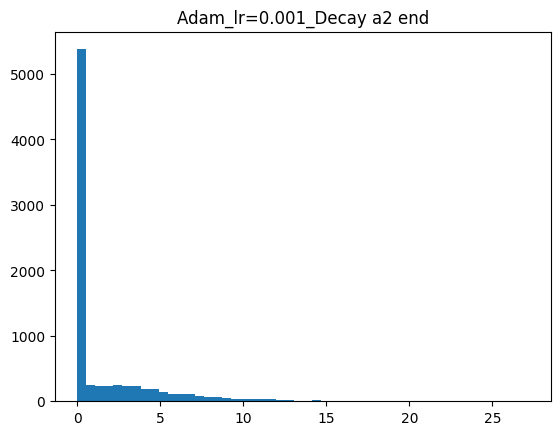

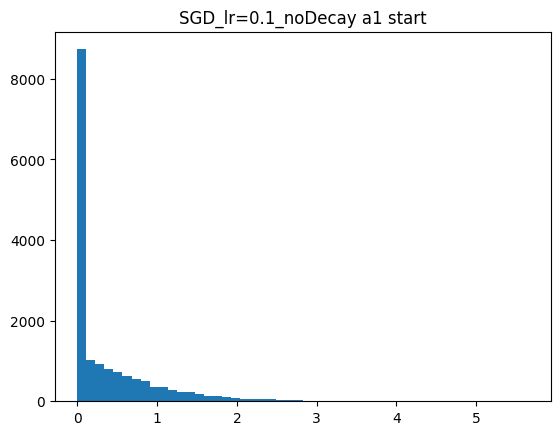

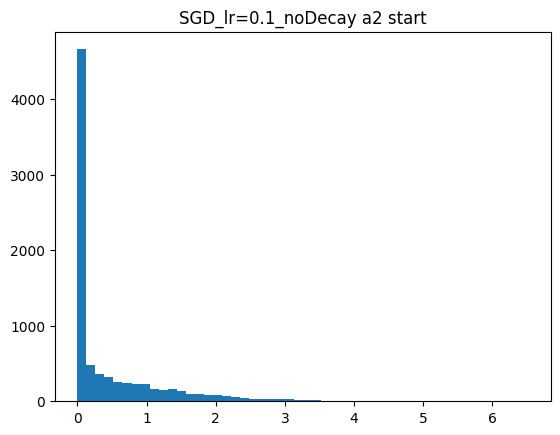

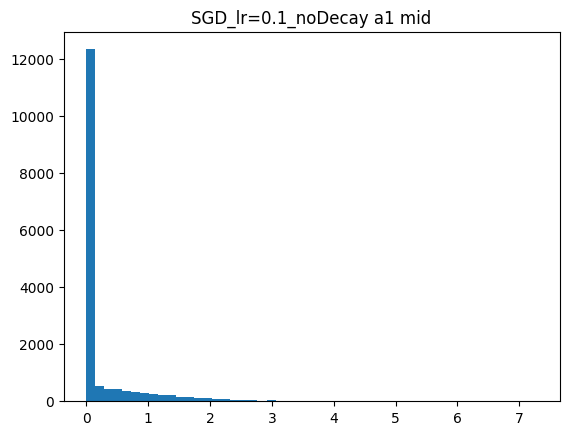

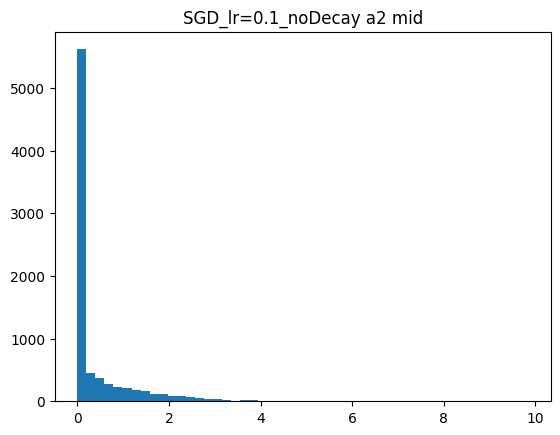

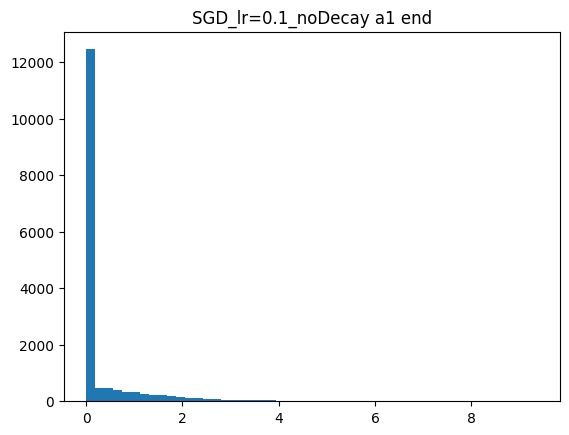

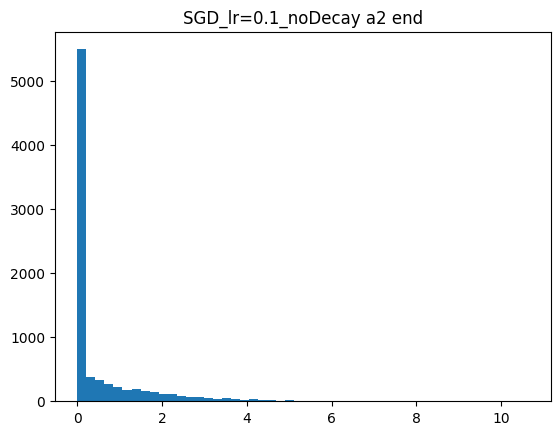

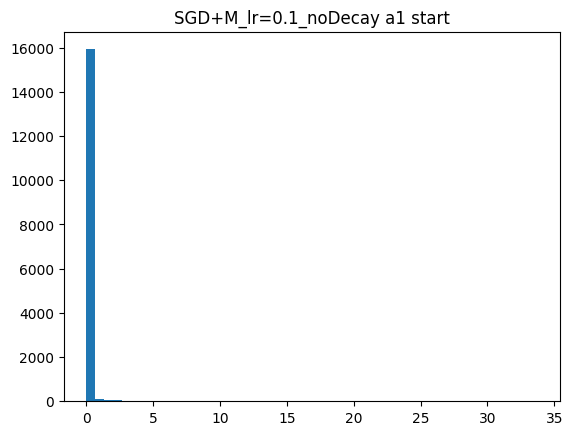

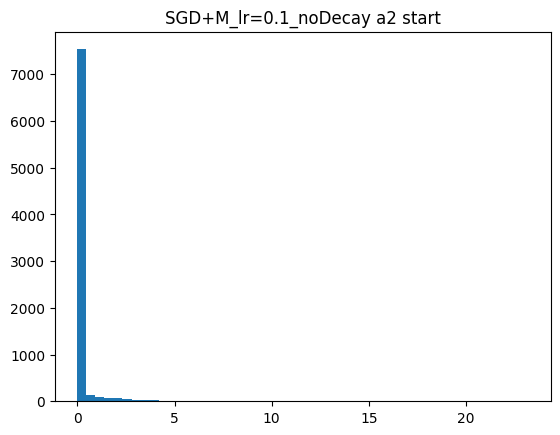

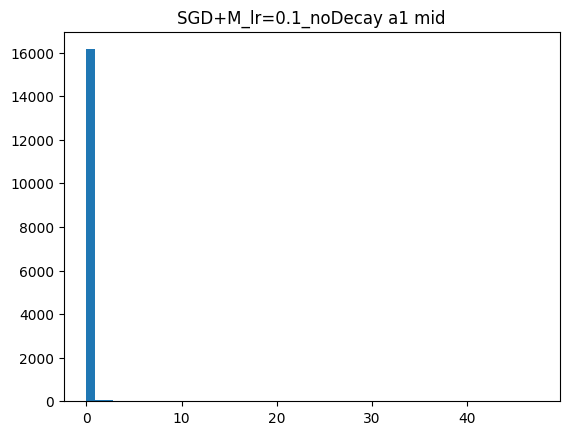

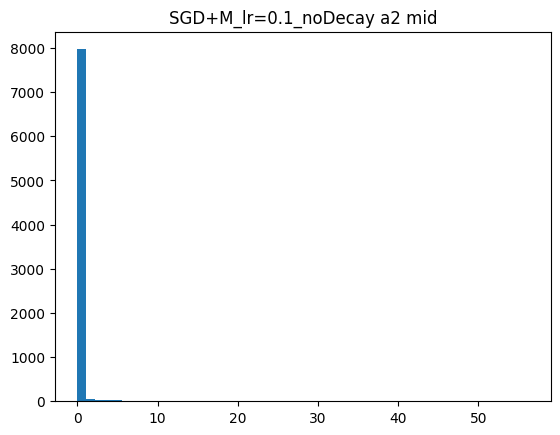

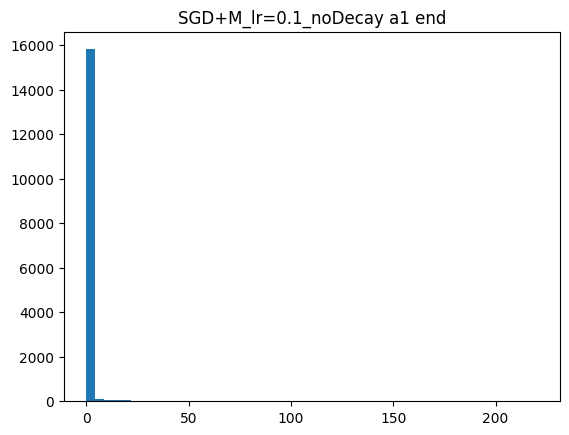

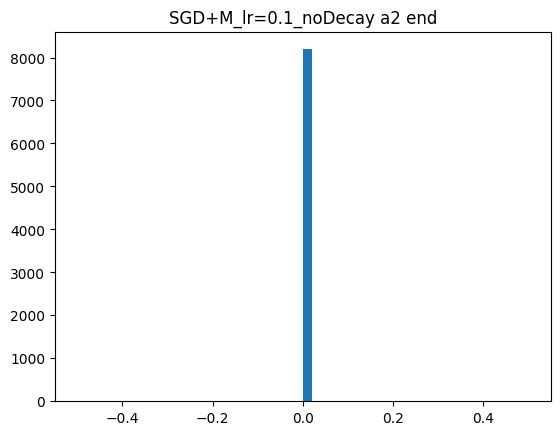

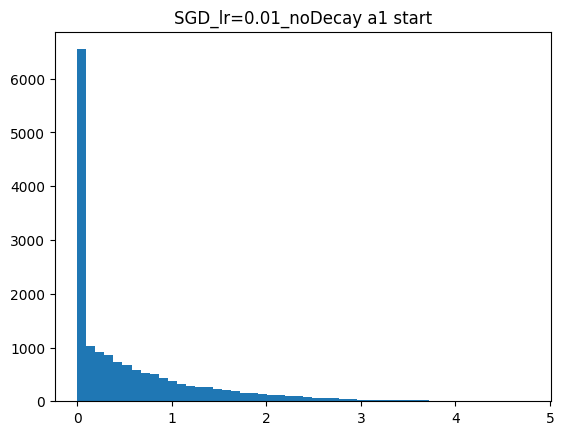

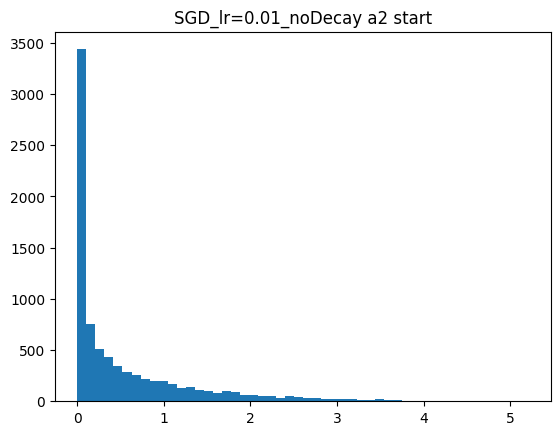

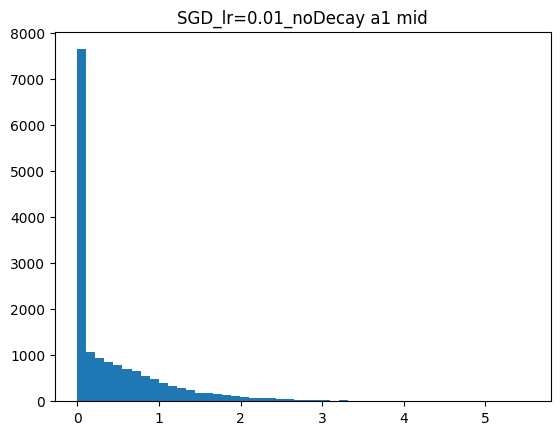

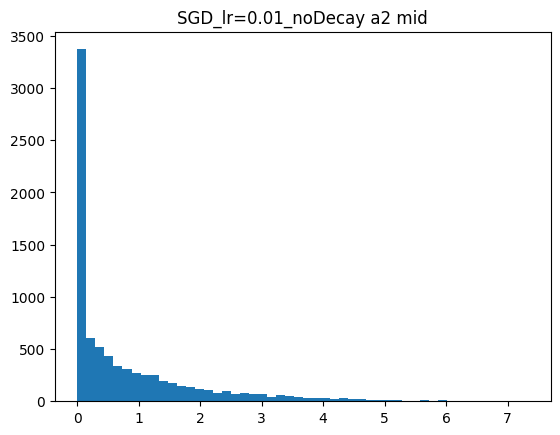

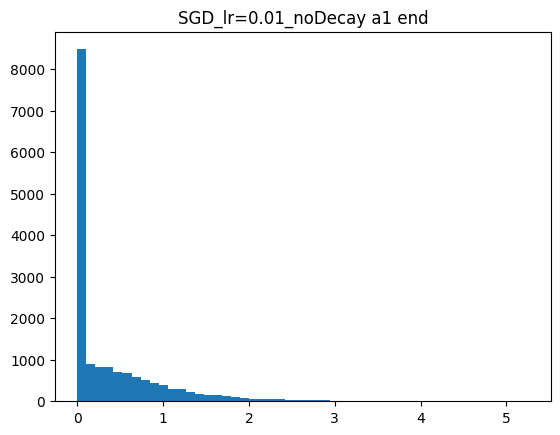

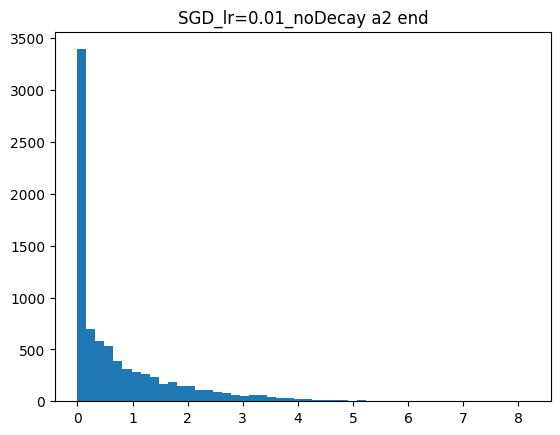

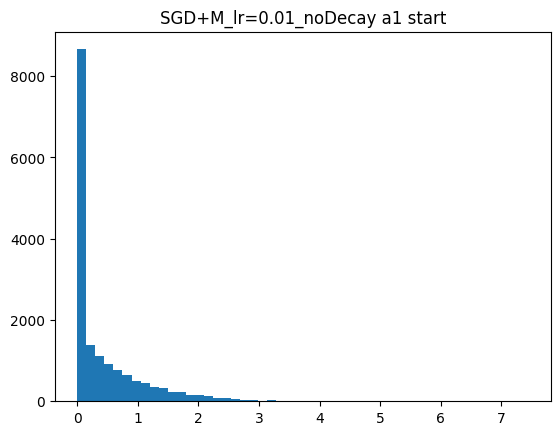

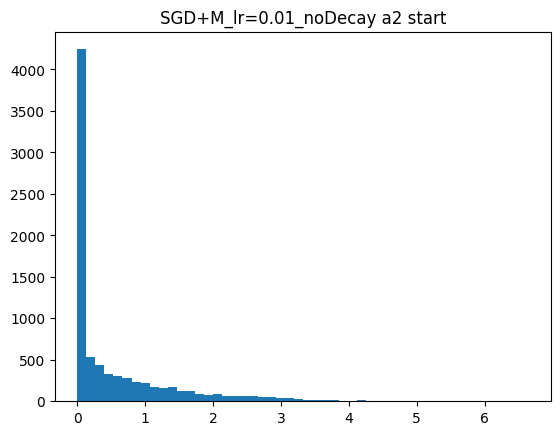

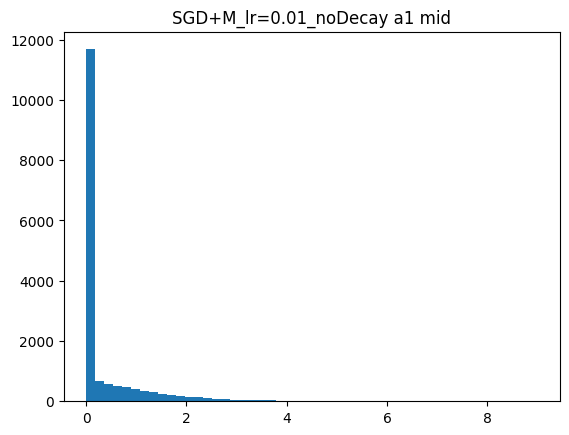

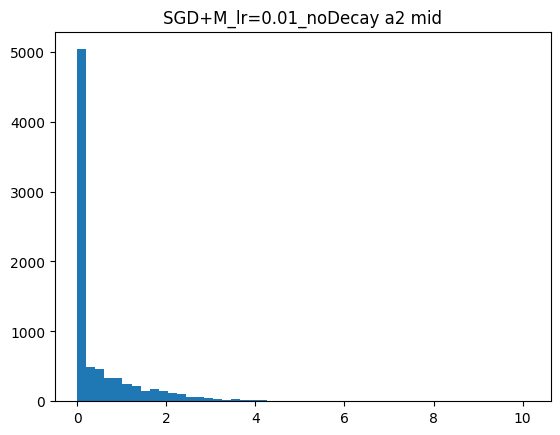

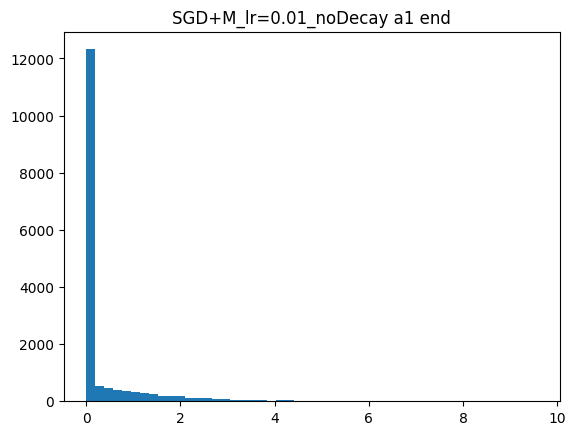

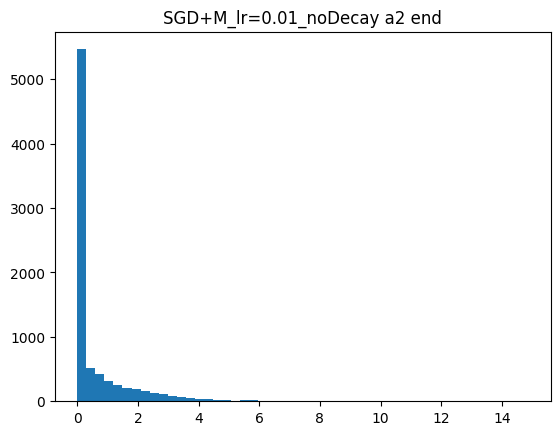

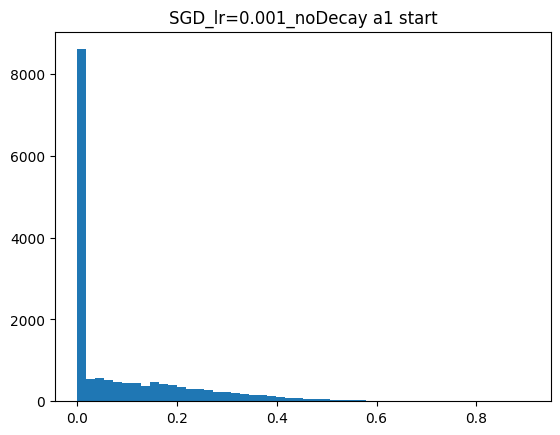

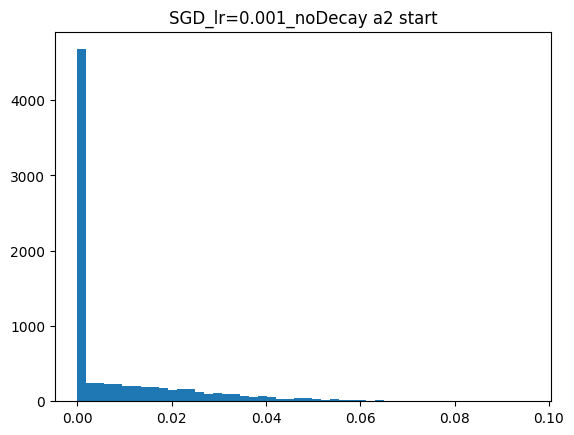

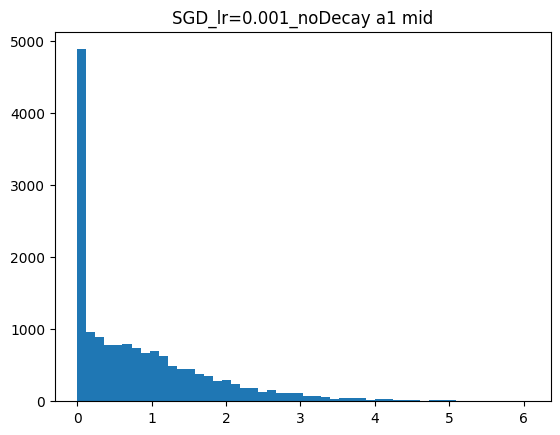

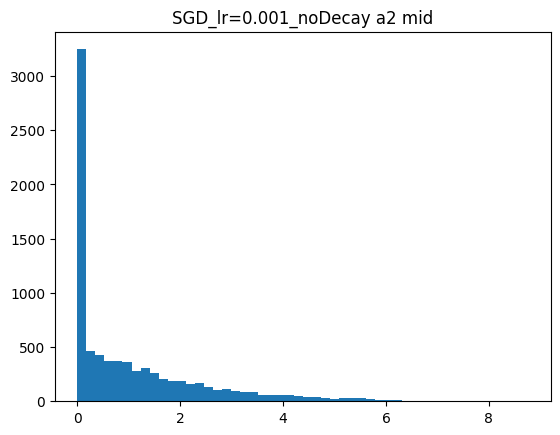

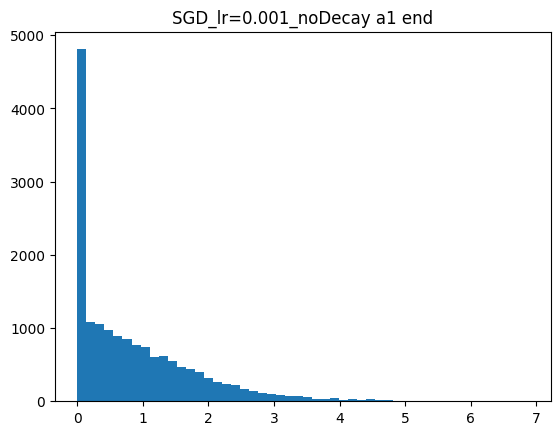

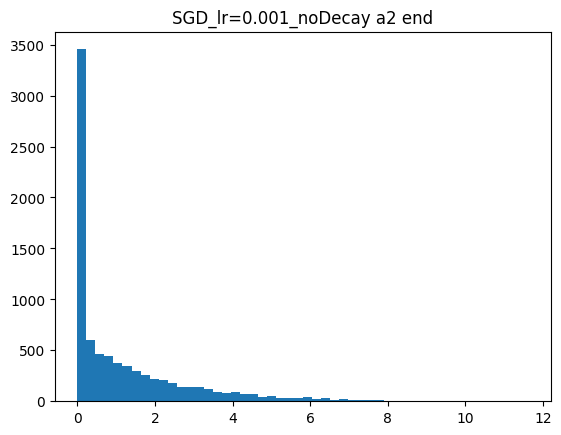

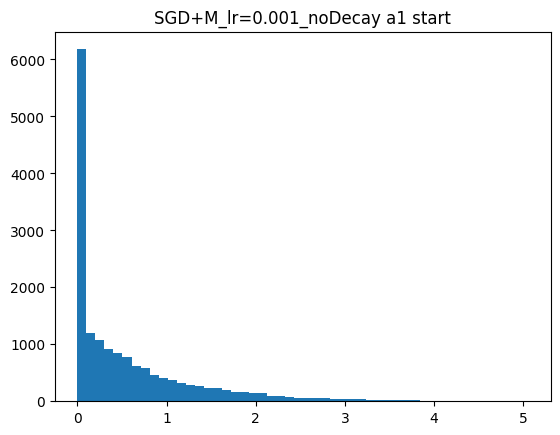

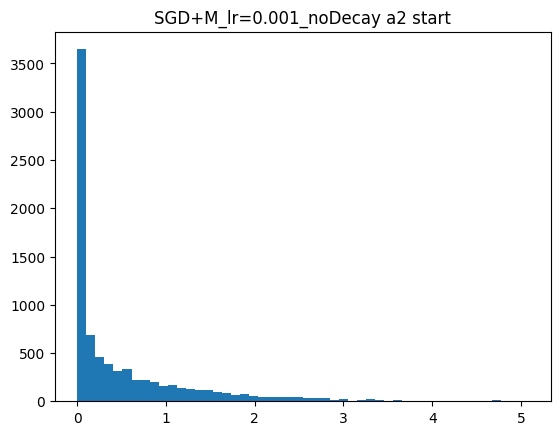

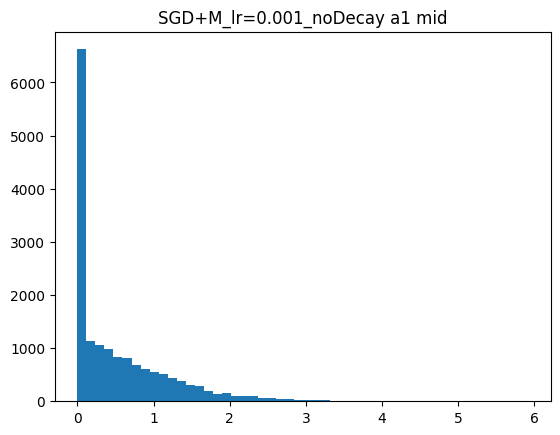

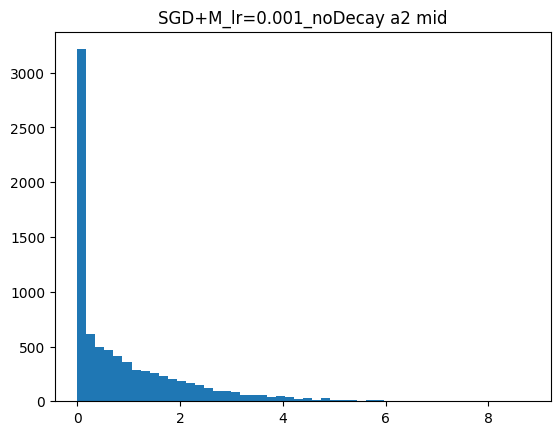

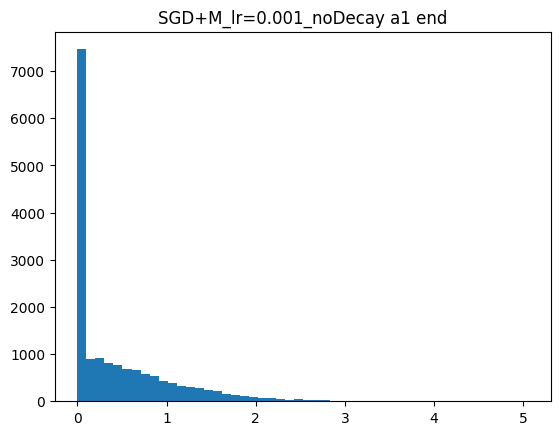

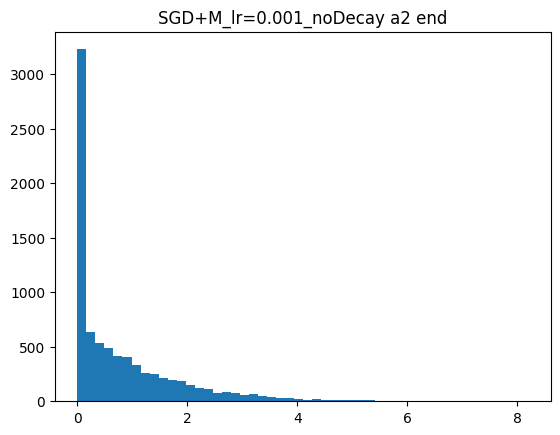

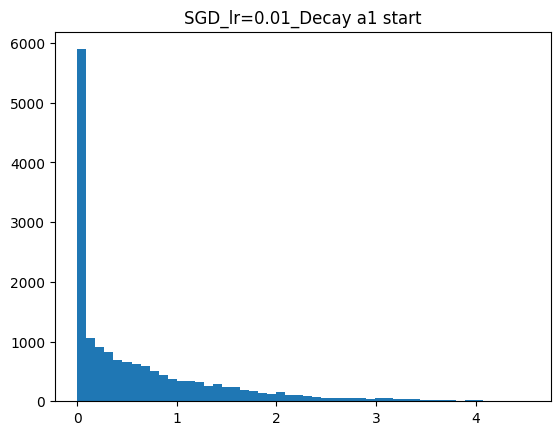

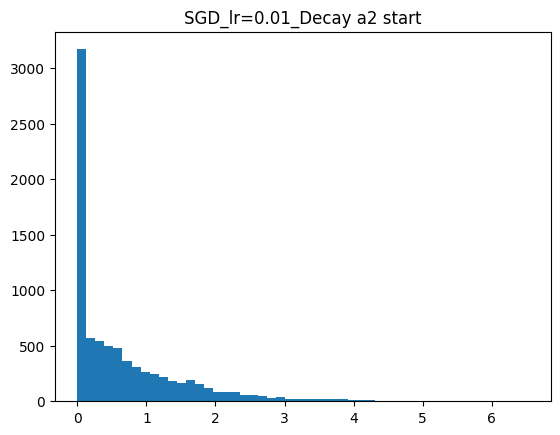

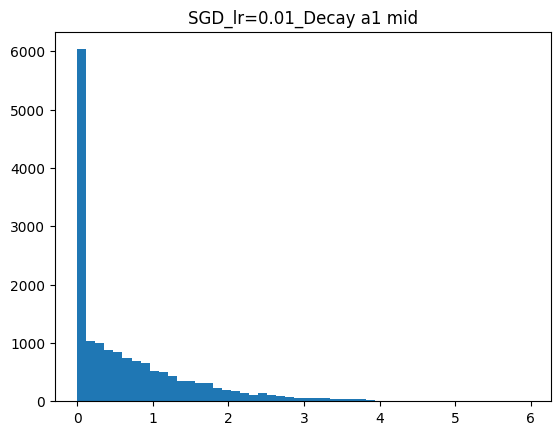

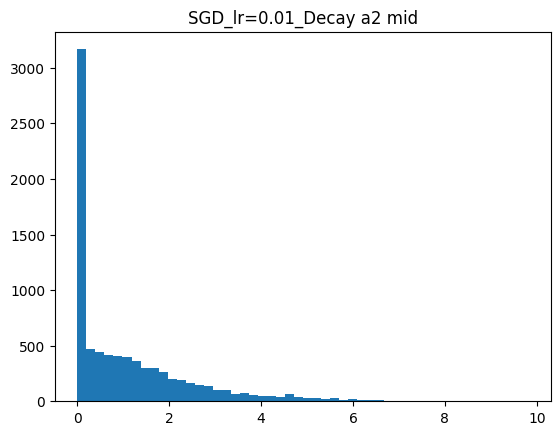

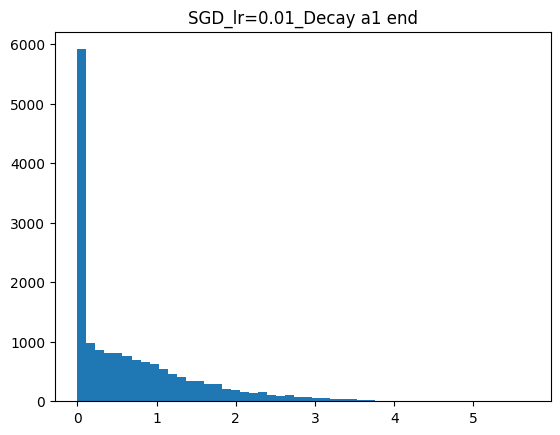

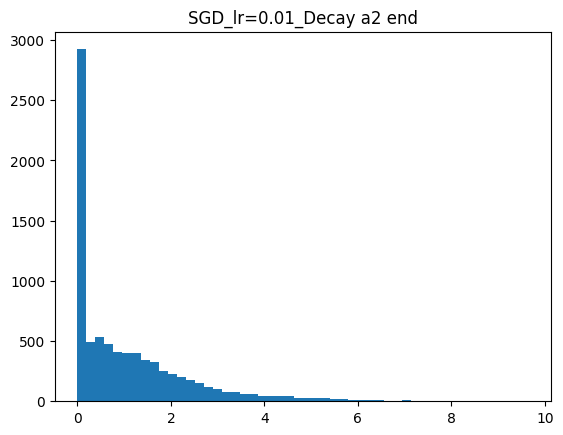

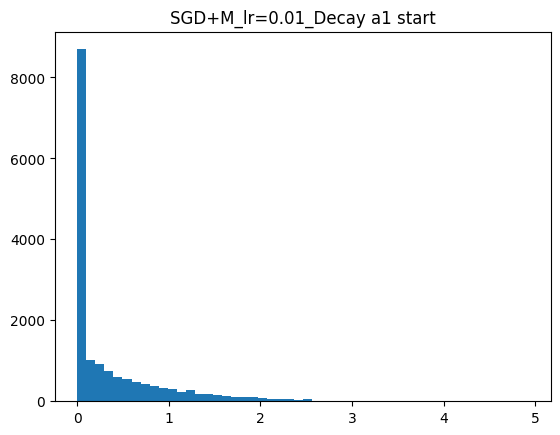

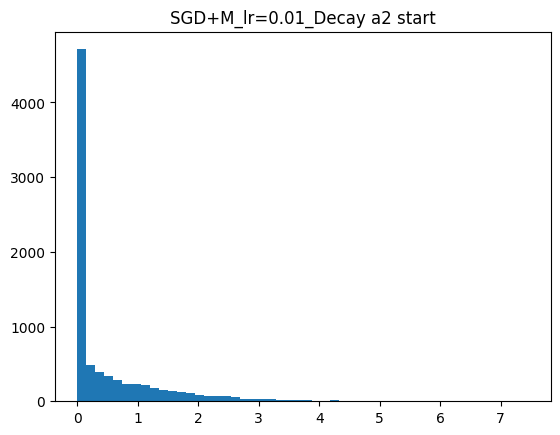

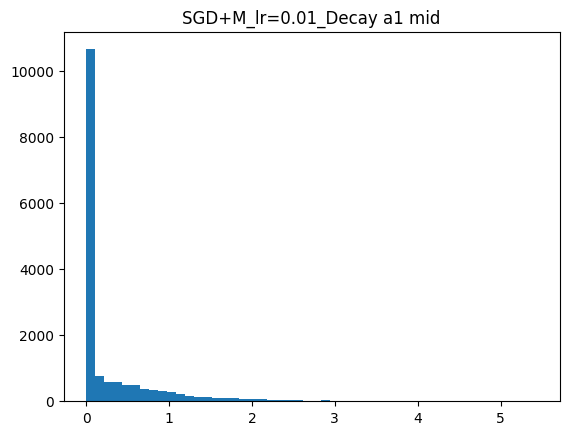

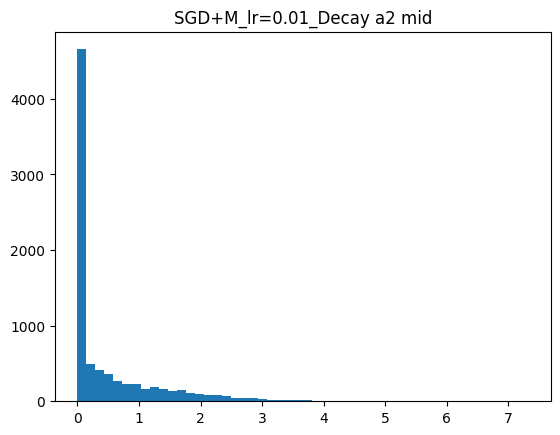

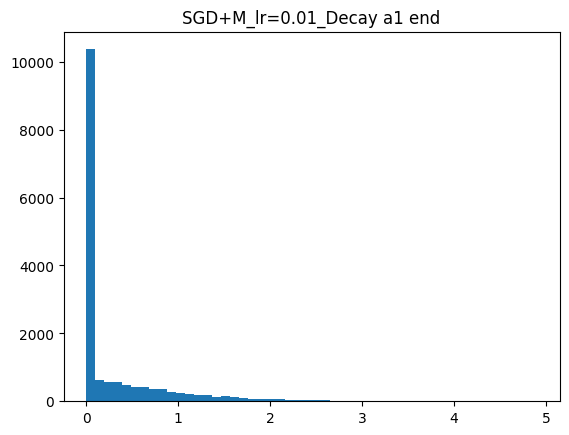

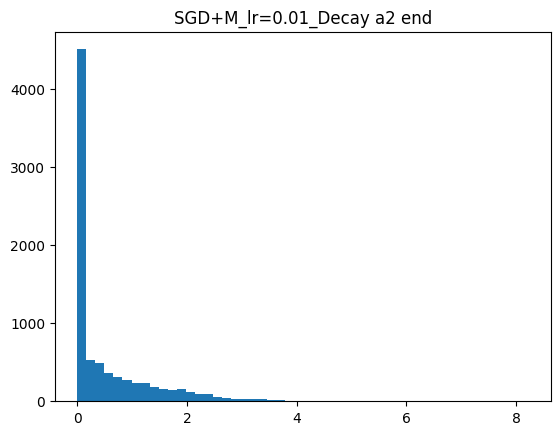

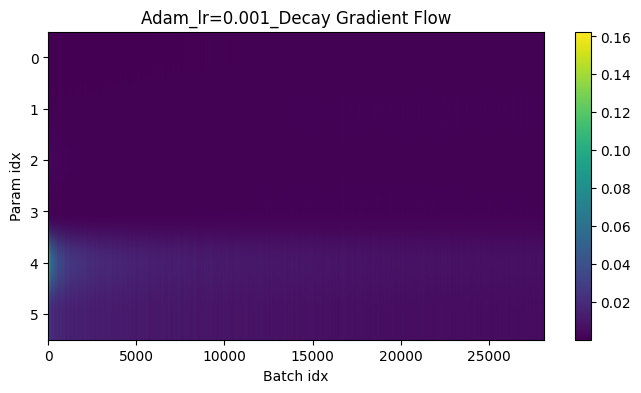

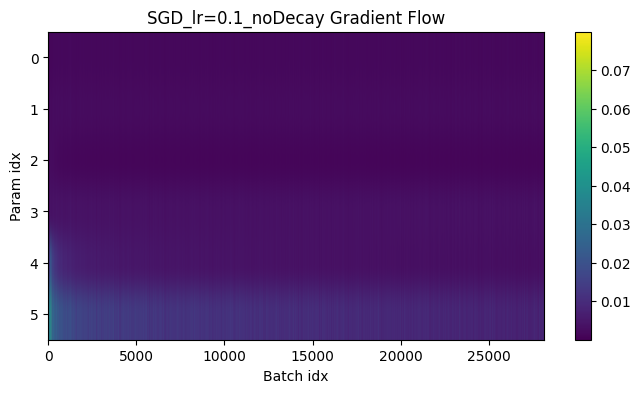

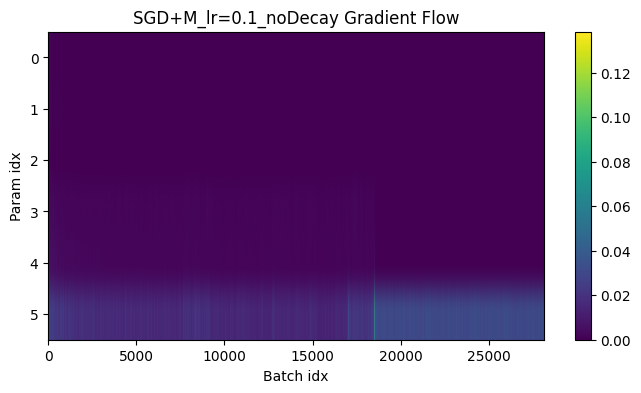

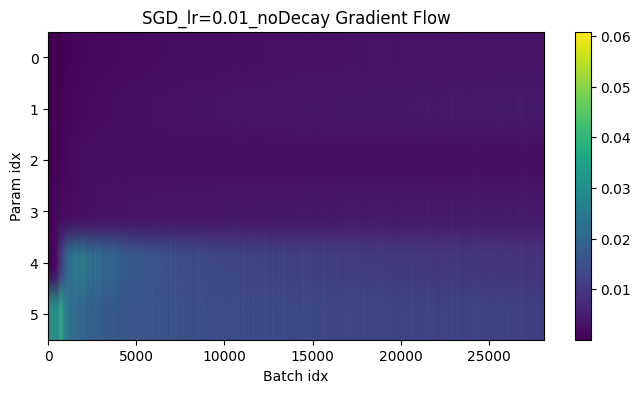

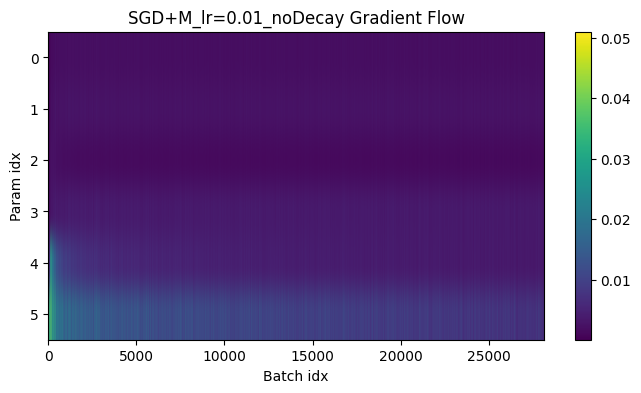

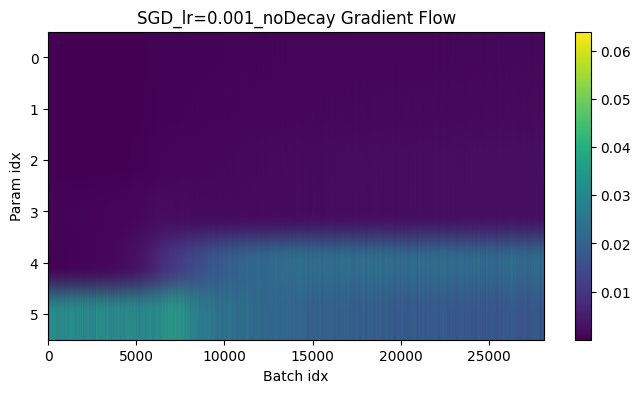

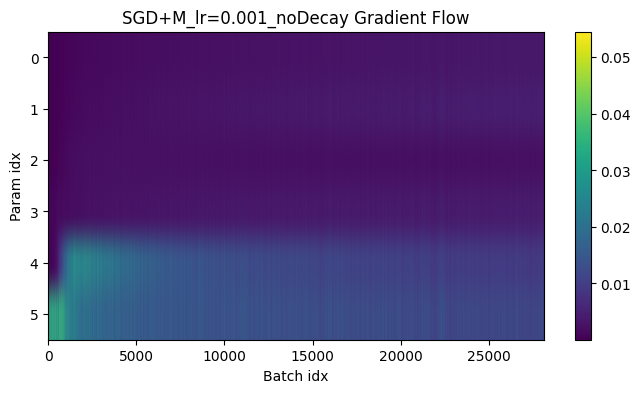

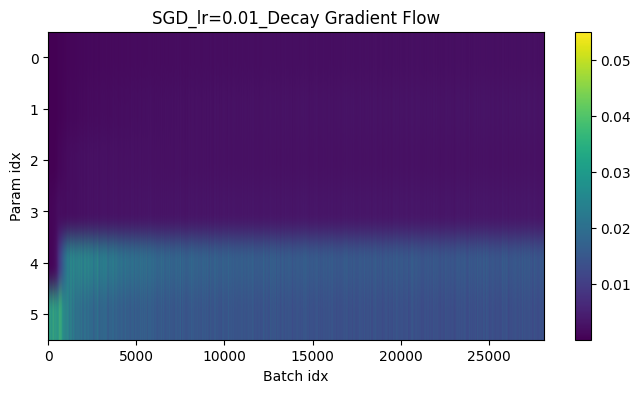

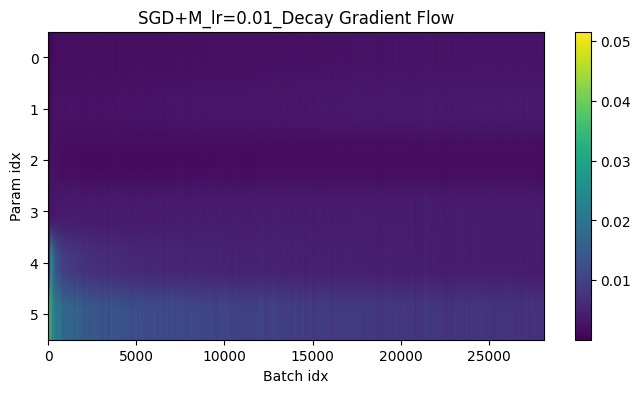

Adam_lr=0.001_Decay imbalance epochs: []
SGD_lr=0.1_noDecay imbalance epochs: [22]
SGD+M_lr=0.1_noDecay imbalance epochs: [15, 25, 28]
SGD_lr=0.01_noDecay imbalance epochs: [23]
SGD+M_lr=0.01_noDecay imbalance epochs: [27]
SGD_lr=0.001_noDecay imbalance epochs: [4, 5, 6, 7]
SGD+M_lr=0.001_noDecay imbalance epochs: []
SGD_lr=0.01_Decay imbalance epochs: [26, 30]
SGD+M_lr=0.01_Decay imbalance epochs: []
| Config                 |   Final Acc (%) |   Epoch to Converge |   Loss Std |   Imbalance Count |
|:-----------------------|----------------:|--------------------:|-----------:|------------------:|
| Adam_lr=0.001_Decay    |           97.18 |                  30 |     0.1052 |                 0 |
| SGD_lr=0.1_noDecay     |           95.06 |                  30 |     0.1266 |                 1 |
| SGD+M_lr=0.1_noDecay   |            9.86 |                  17 |     0.8525 |                 3 |
| SGD_lr=0.01_noDecay    |           89.88 |                  30 |     0.3276 |                

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ======= 설정 =======
batch_size = 64
epochs = 30
input_size = 28 * 28
num_classes = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 실험별 학습률 설정
sgd_lrs = [0.1, 0.01, 0.001]
best_lr = {}  # PART 2에서 채움

# ======= 데이터 로드 =======
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_ds = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# ======= 모델 정의 =======
class MLP_C(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        # 가중치 초기화
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, std=0.01)
                nn.init.zeros_(m.bias)
    def forward(self, x):
        return self.net(x.view(-1, input_size))

# ======= 학습 및 데이터 캡처 함수 =======
def train_capture(name, opt_name, lr, momentum, use_decay):
    model = MLP_C().to(device)
    # 옵티마이저 설정
    if opt_name == 'SGD+M':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    elif opt_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9) if use_decay else None

    # 저장 공간
    losses, accs, lr_hist = [], [], []
    grad_flow = []  # 배치 단위 gradient mean
    act_snap = {}   # 'start','mid','end' 시점 activation
    imbalance = []  # 불균형 epoch
    mid_ep = epochs // 2

    for ep in range(1, epochs+1):
        model.train()
        total_loss, correct = 0.0, 0
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            loss = nn.CrossEntropyLoss()(out, y)
            optimizer.zero_grad()
            loss.backward()
            # gradient 기록
            grad_flow.append([p.grad.abs().mean().item() for p in model.parameters()])
            optimizer.step()
            total_loss += loss.item()
            correct += (out.argmax(1) == y).sum().item()
        # 스케줄러 단계
        if scheduler:
            scheduler.step()
        # 기록
        avg_loss = total_loss / len(loader)
        avg_acc = correct / len(train_ds)
        losses.append(avg_loss)
        accs.append(avg_acc)
        lr_hist.append(scheduler.get_last_lr()[0] if scheduler else lr)
        # 불균형 감지
        if ep > 1 and losses[-1] < losses[-2] and accs[-1] <= accs[-2]:
            imbalance.append(ep)
        # activation snapshot
        if ep in (1, mid_ep, epochs):
            model.eval()
            with torch.no_grad():
                X0, _ = next(iter(loader))
                X0 = X0.to(device)
                # 중간 activation 얻기 위해 분리
                x_view = X0.view(-1, input_size)
                a1 = model.net[0:2](x_view)
                a2 = model.net[2:4](a1)
                tag = 'start' if ep==1 else ('mid' if ep==mid_ep else 'end')
                act_snap[tag] = (a1.cpu().numpy(), a2.cpu().numpy())
            model.train()
        # 로그 출력
        print(f"[{name}] Ep{ep}/{epochs} Loss:{avg_loss:.4f} Acc:{avg_acc*100:.2f}% lr={lr_hist[-1]:.4f}")

    return {
        'losses': losses,
        'accs': accs,
        'lr_hist': lr_hist,
        'grad_flow': np.array(grad_flow).T,
        'act_snap': act_snap,
        'imbalance': imbalance
    }

# ======= PART 1: Adam + No-Decay 실험 =======
results = {}
# Adam: 기본 lr=0.001 + Decay
results['Adam_lr=0.001_Decay'] = train_capture('Adam_lr=0.001_Decay', 'Adam', 0.001, 0, True)
# SGD, SGD+Momentum: No-Decay 3가지 lr
for lr in sgd_lrs:
    results[f'SGD_lr={lr}_noDecay']    = train_capture(f'SGD_lr={lr}_noDecay', 'SGD',    lr, 0,   False)
    results[f'SGD+M_lr={lr}_noDecay']  = train_capture(f'SGD+M_lr={lr}_noDecay','SGD+M', lr, 0.9, False)

# ======= 최적 lr 선별 =======
best_lr = {}
for opt in ['SGD', 'SGD+M']:
    subset = {k:v for k,v in results.items() if k.startswith(opt) and 'noDecay' in k}
    best_key = max(subset, key=lambda x: subset[x]['accs'][-1])
    best_lr[opt] = float(best_key.split('=')[1].split('_')[0])
print("Best learning rates:", best_lr)

# ======= PART 2: Decay 실험 (최적 lr) =======
for opt, lr in best_lr.items():
    name = f"{opt}_lr={lr}_Decay"
    mom = 0.9 if opt=='SGD+M' else 0.0
    results[name] = train_capture(name, opt, lr, mom, True)

# ======= 시각화 =======
eps = range(1, epochs+1)
# Loss vs Epoch
plt.figure(figsize=(10,5))
for k,v in results.items(): plt.plot(eps, v['losses'], label=k)
plt.title('Loss vs Epoch'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(bbox_to_anchor=(1,1)); plt.show()
# Accuracy vs Epoch
plt.figure(figsize=(10,5))
for k,v in results.items(): plt.plot(eps, [a*100 for a in v['accs']], label=k)
plt.title('Accuracy vs Epoch'); plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.legend(bbox_to_anchor=(1,1)); plt.show()

# Activation 히스토그램
for k,v in results.items():
    for tag, (a1,a2) in v['act_snap'].items():
        plt.figure(); plt.hist(a1.ravel(), bins=50); plt.title(f'{k} a1 {tag}'); plt.show()
        plt.figure(); plt.hist(a2.ravel(), bins=50); plt.title(f'{k} a2 {tag}'); plt.show()

# Gradient Flow Heatmap
for k,v in results.items():
    plt.figure(figsize=(8,4)); plt.imshow(v['grad_flow'], aspect='auto'); plt.title(f'{k} Gradient Flow'); plt.xlabel('Batch idx'); plt.ylabel('Param idx'); plt.colorbar(); plt.show()

# 불균형 Epoch 출력
for k,v in results.items(): print(f"{k} imbalance epochs:", v['imbalance'])

# ======= 정량 비교 표 =======
rows = []
for k,v in results.items():
    conv_ep = v['losses'].index(min(v['losses'])) + 1
    stability = round(np.std(v['losses']), 4)
    imbalance_count = len(v['imbalance'])
    rows.append({
        'Config': k,
        'Final Acc (%)': round(v['accs'][-1]*100, 2),
        'Epoch to Converge': conv_ep,
        'Loss Std': stability,
        'Imbalance Count': imbalance_count
    })

df = pd.DataFrame(rows)
print(df.to_markdown(index=False))
